# Import Libraries

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import re
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from pandas_datareader import data
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation, LSTM
from tensorflow.python.keras.optimizer_v2 import rmsprop
from keras.optimizers import Adam
from keras.regularizers import l2
import keras
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from matplotlib import pyplot
import statistics 
import math


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading and Normalize data

---




In [ ]:
start_date = '2008-12-31'
end_date = '2020-11-02'

apple_raw = data.DataReader('AAPL', 'yahoo', start_date, end_date).reset_index()
apple_df = apple_raw[['Date', 'Close']]
apple_df.set_index('Date', inplace= True)
apple_df = apple_df.resample('D').mean()
apple_df = apple_df.fillna(method='ffill')
apple_df = apple_df.loc[apple_df.index < pd.to_datetime('2020-11-01')]  

apple_df['Lag_Close_value'] = apple_df['Close'].shift(1)
apple_df = apple_df.iloc[2:]
apple_df

,Close,Lag_Close_value
Date,,
2009-01-02,3.241071,3.048214
2009-01-03,3.241071,3.241071
2009-01-04,3.241071,3.241071
2009-01-05,3.377857,3.241071
2009-01-06,3.322143,3.377857
...,...,...
2020-10-27,116.599998,115.050003
2020-10-28,111.199997,116.599998
2020-10-29,115.320000,111.199997


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=apple_df['Close'])
scaler.fit(df)
apple_df['Close'] = scaler.transform(df)

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=apple_df['Lag_Close_value'])
scaler.fit(df)
apple_df['Lag_Close_value'] = scaler.transform(df)

In [ ]:
aapl_trend = pd.read_excel('/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Google Trend data/Excel/AAPL_Trend.xlsx')
aapl_trend['Month'] = pd.to_datetime(aapl_trend['Month'])

apple_trend = pd.read_excel('/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Google Trend data/Excel/Apple_Trend.xlsx')
apple_trend = apple_trend.iloc[:, 1]

iphone_trend = pd.read_excel('/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Google Trend data/Excel/IPhone_Trend.xlsx')
iphone_trend = iphone_trend.iloc[:, 1]

macbook_trend = pd.read_excel('/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Google Trend data/Excel/MacBook_Trend.xlsx')
macbook_trend = macbook_trend.iloc[:, 1]

nasdaq_trend = pd.read_excel('/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Google Trend data/Excel/NASDAQ-AAPL_Trend.xlsx')
nasdaq_trend = nasdaq_trend.iloc[:, 1]

google_trend_df = pd.concat([aapl_trend, apple_trend, iphone_trend, macbook_trend, nasdaq_trend], axis=1)
google_trend_df.set_index('Month')

google_trend_df = google_trend_df.set_index('Month')
google_trend_df = google_trend_df.resample('D').mean()
google_trend_df = google_trend_df.fillna(method='ffill')
google_trend_df = google_trend_df.loc[google_trend_df.index > pd.to_datetime('2009-01-01')]  
google_trend_df = google_trend_df.loc[google_trend_df.index < pd.to_datetime('2020-11-01')]  
google_trend_df



,AAPL: (Worldwide),Apple: (Worldwide),iPhone: (Worldwide),MacBook: (Worldwide),NASDAQ AAPL: (Worldwide)
Month,,,,,
2009-01-02,38.0,29.0,22.0,63.0,3.0
2009-01-03,38.0,29.0,22.0,63.0,3.0
2009-01-04,38.0,29.0,22.0,63.0,3.0
2009-01-05,38.0,29.0,22.0,63.0,3.0
2009-01-06,38.0,29.0,22.0,63.0,3.0
...,...,...,...,...,...
2020-10-27,68.0,50.0,61.0,73.0,61.0
2020-10-28,68.0,50.0,61.0,73.0,61.0
2020-10-29,68.0,50.0,61.0,73.0,61.0


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=google_trend_df['AAPL: (Worldwide)'])
scaler.fit(df)
google_trend_df['AAPL: (Worldwide)'] = scaler.transform(df)

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=google_trend_df['Apple: (Worldwide)'])
scaler.fit(df)
google_trend_df['Apple: (Worldwide)'] = scaler.transform(df)

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=google_trend_df['iPhone: (Worldwide)'])
scaler.fit(df)
google_trend_df['iPhone: (Worldwide)'] = scaler.transform(df)

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=google_trend_df['MacBook: (Worldwide)'])
scaler.fit(df)
google_trend_df['MacBook: (Worldwide)'] = scaler.transform(df)

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=google_trend_df['NASDAQ  AAPL: (Worldwide)'])
scaler.fit(df)
google_trend_df['NASDAQ  AAPL: (Worldwide)'] = scaler.transform(df)

In [ ]:
# All tweets with haashtag and cashtag appl
# Need to do AAPL
twitterdf = pd.read_csv('/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Combined_Tweet_Sent.csv')
twitterdf = twitterdf[['date', 'compound_sentiment']]
twitterdf = twitterdf[['date', 'compound_sentiment']]

twitterdf['date'] = pd.to_datetime(twitterdf['date'])

twitterdf = twitterdf.set_index('date')
twitterdf = twitterdf.resample('D').mean()
twitterdf = twitterdf.fillna(0)
twitterdf = twitterdf.loc[twitterdf.index > pd.to_datetime('2009-01-01')]  
twitterdf = twitterdf.loc[twitterdf.index < pd.to_datetime('2020-11-01')]  
twitterdf

,compound_sentiment
date,
2009-01-02,0.180712
2009-01-03,-0.230400
2009-01-04,0.000000
2009-01-05,0.080633
2009-01-06,0.116537
...,...
2020-10-27,0.146439
2020-10-28,0.070818
2020-10-29,0.090312


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=twitterdf['compound_sentiment'])
scaler.fit(df)
twitterdf['compound_sentiment'] = scaler.transform(df)

In [ ]:
twitterdf

,compound_sentiment
date,
2009-01-02,0.571270
2009-01-03,0.333211
2009-01-04,0.466627
2009-01-05,0.513318
2009-01-06,0.534109
...,...
2020-10-27,0.551424
2020-10-28,0.507635
2020-10-29,0.518923


In [ ]:
headlines_sent = pd.read_csv(r'/content/drive/Shareddrives/IoTAnalytics/GROUP-EE8225-IoT/Project_Data/Headlines_Sentiment.csv')

headlines_sent = headlines_sent[['date', 'num of comments', 'compound_sentiment']]

headlines_sent['date'] = pd.to_datetime(headlines_sent['date'])


headlines_sent = headlines_sent.set_index('date')
headlines_sent = headlines_sent.resample('D').mean()
headlines_sent = headlines_sent.fillna(0)
headlines_sent = headlines_sent.loc[headlines_sent.index > pd.to_datetime('2009-01-01')]  
headlines_sent = headlines_sent.loc[headlines_sent.index < pd.to_datetime('2020-11-01')] 


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=headlines_sent['num of comments'])
scaler.fit(df)
headlines_sent['num of comments'] = scaler.transform(df)

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(data=headlines_sent['compound_sentiment'])
scaler.fit(df)
headlines_sent['compound_sentiment'] = scaler.transform(df)

In [ ]:
headlines_sent

,num of comments,compound_sentiment
date,,
2009-01-02,0.000000,0.430211
2009-01-03,0.000000,0.254201
2009-01-04,0.000000,0.465924
2009-01-05,0.001163,0.493364
2009-01-06,0.000873,0.543485
...,...,...
2020-10-27,0.066318,0.465924
2020-10-28,0.027923,0.298009
2020-10-29,0.116928,0.434814


# Correlation Analysis

In [ ]:
twitterdf = twitterdf.rename(columns={"compound_sentiment": "Twitter_Sent"})
headlines_sent = headlines_sent.rename(columns={"num of comments": "News_#_comments", "compound_sentiment": "News_Sent"})
result = pd.concat([google_trend_df, twitterdf, headlines_sent, apple_df], axis=1, sort=False)
result.index.names = ['Date']
result

,AAPL: (Worldwide),Apple: (Worldwide),iPhone: (Worldwide),MacBook: (Worldwide),NASDAQ AAPL: (Worldwide),Twitter_Sent,News_#_comments,News_Sent,Close,Lag_Close_value
Date,,,,,,,,,,
2009-01-02,0.215190,0.077922,0.012658,0.26,0.010204,0.571270,0.000000,0.430211,0.003411,0.001944
2009-01-03,0.215190,0.077922,0.012658,0.26,0.010204,0.333211,0.000000,0.254201,0.003411,0.003411
2009-01-04,0.215190,0.077922,0.012658,0.26,0.010204,0.466627,0.000000,0.465924,0.003411,0.003411
2009-01-05,0.215190,0.077922,0.012658,0.26,0.010204,0.513318,0.001163,0.493364,0.004452,0.003411
2009-01-06,0.215190,0.077922,0.012658,0.26,0.010204,0.534109,0.000873,0.543485,0.004028,0.004452
...,...,...,...,...,...,...,...,...,...,...
2020-10-27,0.594937,0.350649,0.506329,0.46,0.602041,0.551424,0.066318,0.465924,0.866197,0.854400
2020-10-28,0.594937,0.350649,0.506329,0.46,0.602041,0.507635,0.027923,0.298009,0.825097,0.866197
2020-10-29,0.594937,0.350649,0.506329,0.46,0.602041,0.518923,0.116928,0.434814,0.856455,0.825097


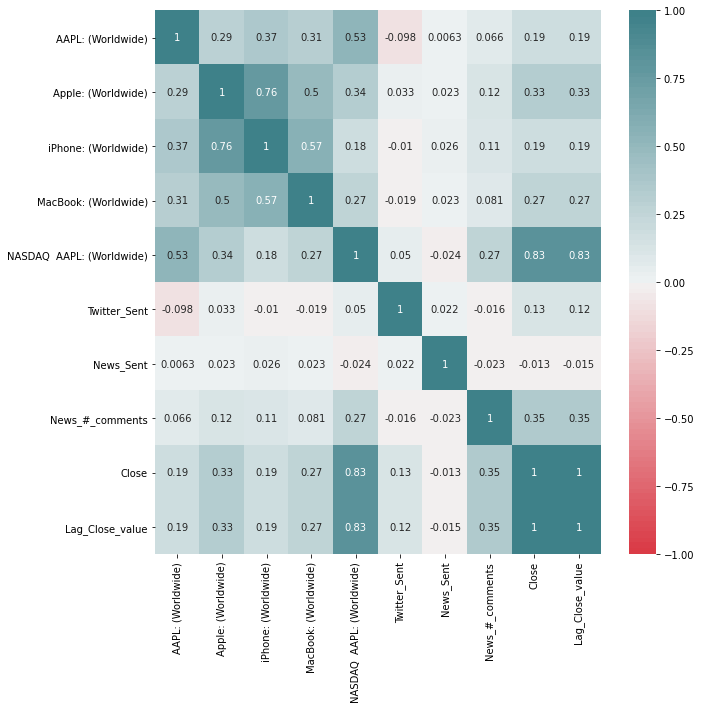

In [ ]:
import seaborn as sns

result = pd.concat([google_trend_df, twitterdf['Twitter_Sent'], headlines_sent['News_Sent'],headlines_sent['News_#_comments'] , apple_df], axis=1, sort=False)
result.index.names = ['Date']
#result
# Creating a heatmap for correlation
corr = result.corr()
plt.figure(figsize=(10,10))
hm = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 205, n = 100, center = 'light'), annot=True)

# Data Preprocessing
---


- Split the X, y = split_sequences, into train and test. Input only train into the model
- Play with how many days are being trained on and days forecasted: 
n_steps_in, n_steps_out = 90, 8

In [ ]:
# Converting Dataframe to numpy arrays
F0 = google_trend_df.iloc[:,0].values
F1 = google_trend_df.iloc[:,1].values
F2 = google_trend_df.iloc[:,2].values
F3 = google_trend_df.iloc[:,3].values
F4 = google_trend_df.iloc[:,4].values
F5 = twitterdf.iloc[:,0].values
F6 = headlines_sent.iloc[:,0].values
F7 = headlines_sent.iloc[:,1].values
# Using the lag_close
F8 = apple_df.iloc[:,1].values
# Target is a feature
Target = apple_df.iloc[:,0].values



In [ ]:
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples (Black Box)
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# convert to [rows, columns] structure so it can be fed into LSTM model
F0 = F0.reshape((len(F0), 1))
F1 = F1.reshape((len(F1), 1))
F2 = F2.reshape((len(F2), 1))
F3 = F3.reshape((len(F3), 1))
F4 = F4.reshape((len(F4), 1))
F5 = F5.reshape((len(F5), 1))
F6 = F6.reshape((len(F6), 1))
F7 = F7.reshape((len(F7), 1))
F8 = F8.reshape((len(F8), 1))

Target = Target.reshape((len(Target), 1))

# horizontally stack columns
#dataset = hstack((F0, F1, F2, F3, F4, F5, F6, F7, Target))
#dataset = hstack((F0, F1, F2, F3, F4, F6, F7, F8, Target))
#dataset = hstack((F0, F1, F2, F3, F4, F6, F8, Target))
#dataset = hstack((F0, F1, F2, F3, F4, F6, F8, Target))
#dataset = hstack((F2, F3, F4, F6, F7, F8, Target))

# Features from Linear Regression Coefficient Ranking 
dataset = hstack((F2, F4, F5, F7, F8, Target))

n_steps_in, n_steps_out = 90, 8

# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)

n_features = X.shape[2]
print(n_features)

# Split X and y into train, test 
# train = 75
# val = 15
# test = 10
#x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.167, shuffle=False)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.22222, shuffle=False)
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.15, shuffle=False) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.24, shuffle=False)

(4225, 90, 5) (4225, 8)
5


In [ ]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)


(2729, 90, 5) (2729, 8) (862, 90, 5) (862, 8) (634, 90, 5) (634, 8)


# LSTM Model

- Layers.
- Validation Split
- LSTM units. 
- Epochs < 75
- Setting validation data as test data
- Adding additional losses (MAE, MSE etc.) 

In [ ]:
def model_predict(model, n_steps_in, n_features, x_test):
  yhat = np.zeros((len(x_test),8))
  #print(y_test.shape)
  for x in range(0,len(x_test)):
    x_input = x_test[x,:,:]
    yhat[x,:] = model.predict(x_input.reshape((1, n_steps_in, n_features)), verbose=0)
  return yhat


In [ ]:
# SMAPE
def smape_error(y_test, yhat):
  smape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    smape[x] = ((1/n_steps_out)*sum(((2*np.abs(y_test[x,:] - yhat[x,:]))/(np.abs(y_test[x,:]) + np.abs(yhat[x,:])))))*100
  print("Min SMAPE %:")
  print(min(smape))
  print("Mean SMAPE %:")
  print(sum(smape)/len(y_test))
  print("Median SMAPE %:")
  print(statistics.median(smape))
  print("Max SMAPE %:")
  print(max(smape))
  return smape

In [ ]:
# MAAPE
def maape_error(y_test, yhat):
  maape = np.zeros(len(yhat))
  arctan = np.zeros(8)
  for x in range(0, len(yhat)):
    #maape[x] = ((1/8)*sum(math.atan(np.abs((y_test[x,:] - yhat[x,:])/y_test[x,:]))))*100
    for y in range(0,8):
      arctan[y] = math.atan(np.abs((y_test[x,y] - yhat[x,y])/y_test[x,y]))
    #print(arctan[:])
    maape[x] = ((1/n_steps_out)*sum(arctan[:]))*100 
  print("Min MAAPE %:")
  print(min(maape))
  print("Mean MAAPE %:")
  print(sum(maape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(maape))
  print("Max MAAPE %:")
  print(max(maape))
  return maape

In [ ]:
# MAPE
def mape_error(y_test, yhat):
  mape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    mape[x] = ((1/n_steps_out)*sum((np.abs((y_test[x,:] - yhat[x,:])/y_test[x,:]))))*100
  print("Min MAPE %:")
  print(min(mape))
  print("Mean MAPE %:")
  print(sum(mape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(mape))
  print("Max MAPE %:")
  print(max(mape))
  return mape


In [ ]:
# old model
# def build_model(units_lstm, n_steps_in, n_steps_out, n_features, ep, x_train, y_train, x_val, y_val):
#   model = Sequential()
#   model.add(LSTM(units_lstm, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#   #model.add(LSTM(units_lstm, activation='relu'))
#   model.add(LSTM(units_lstm, activation='relu'))
#   model.add(Dense(n_steps_out))
#   model.compile(optimizer='adam', loss=tf.keras.losses.mean_absolute_percentage_error)
#   # Fitting the RNN to the Training set
#   #history = model.fit(x_train, y_train, epochs=75, verbose=1, )
#   history = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), shuffle=True, verbose=1)
#   return model, history

In [ ]:
def build_model(units_lstm, n_steps_in, n_steps_out, n_features, ep, x_train, y_train, x_val, y_val, shuff):
  model = Sequential()
  model.add(LSTM(units_lstm, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(Dropout(0.4))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  # Fitting the RNN to the Training set
  history = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), shuffle=shuff, verbose=1)
  return model, history

In [ ]:
[model_feat2, history_feat2] = build_model(64, n_steps_in, n_steps_out, n_features, 50, x_train, y_train, x_val, y_val, shuff= True)

Epoch 1/50
86/86 [==============================] - 12s 135ms/step - loss: 0.0054 - val_loss: 0.0121
Epoch 2/50
86/86 [==============================] - 12s 134ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 3/50
86/86 [==============================] - 11s 133ms/step - loss: 7.5108e-04 - val_loss: 0.0021
Epoch 4/50
86/86 [==============================] - 11s 131ms/step - loss: 5.3977e-04 - val_loss: 8.4089e-04
Epoch 5/50
86/86 [==============================] - 12s 134ms/step - loss: 4.1544e-04 - val_loss: 0.0014
Epoch 6/50
86/86 [==============================] - 11s 133ms/step - loss: 3.6261e-04 - val_loss: 0.0014
Epoch 7/50
86/86 [==============================] - 11s 131ms/step - loss: 3.2549e-04 - val_loss: 4.0836e-04
Epoch 8/50
86/86 [==============================] - 11s 132ms/step - loss: 3.1426e-04 - val_loss: 7.7991e-04
Epoch 9/50
86/86 [==============================] - 11s 132ms/step - loss: 2.7711e-04 - val_loss: 8.4220e-04
Epoch 10/50
86/86 [============================

In [ ]:
def plot_model(history):  
  # plot train and validation loss
  pyplot.plot(history.history['loss'][:])
  pyplot.plot(history.history['val_loss'][:])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')

  pyplot.show()

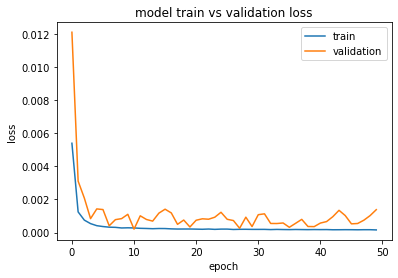

In [ ]:
plot_model(history_feat2)

In [ ]:
# yhat = model_predict(model_feat, n_steps_in, n_features, x_test)


In [ ]:
yhat2 = model_predict(model_feat2, n_steps_in, n_features, x_test)


In [ ]:
# MSE
from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,yhat2))

0.005348855839504236


In [ ]:
# mape with all
mape1 = mape_error(y_test, yhat2)

Min MAPE %:
1.8772680019938408
Mean MAPE %:
13.330483539692983
Median MAPE %:
13.985538280488692
Max MAPE %:
23.6436380176868


In [ ]:
maape1 = maape_error(y_test, yhat2)

Min MAAPE %:
1.8765347573815527
Mean MAAPE %:
13.23014076687105
Median MAPE %:
13.894168954667432
Max MAAPE %:
23.206325944419586


In [ ]:
smape1 = smape_error(y_test, yhat2)

Min SMAPE %:
1.8617400539290612
Mean SMAPE %:
14.392348508631605
Median SMAPE %:
15.042795367682388
Max SMAPE %:
26.851254452983596


In [ ]:
def plot_results(y_test, yhat):  
  # plot train and validation loss
  pred = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    pred[x] = ((1/n_steps_out)*sum((np.abs((yhat[x,:])))))
  pyplot.plot(pred[:])
  pyplot.plot(Target[int(len(Target)-len(yhat)):])
  pyplot.title('Actual vs Prediction')
  pyplot.ylabel('DailyTotals')
  pyplot.xlabel('Day')
  pyplot.legend(['Pred', 'Act'], loc='upper right')

  pyplot.show()


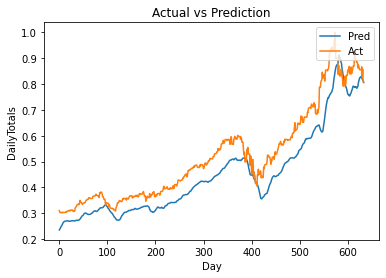

In [ ]:
from matplotlib import pyplot as pyplot
plot_results(y_test, yhat2)

# ARIMA Model


*   Separate train and test sets 
*   Predict one day from the test set at a time

*   Append prediction to historical data, and predict the next day
*   Repeat





In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = apple_df['Close']

In [ ]:
# MAPE
def mape_arima(y_test, yhat):
  mape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    mape[x] = ((np.abs((y_test[x] - yhat[x])/y_test[x])))*100

  print("Min MAPE %:")
  print(min(mape))
  print("Mean MAPE %:")
  print(sum(mape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(mape))
  print("Max MAPE %:")
  print(max(mape))
  return mape

In [ ]:
# MAAPE
def maape_arima(y_test, yhat):
  maape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    # maape[x] = (sum(math.atan(np.abs((y_test[x] - yhat[x])/y_test[x]))))*100
    maape[x] = (math.atan(np.abs((y_test[x] - yhat[x])/y_test[x])))*100

  print("Min MAAPE %:")
  print(min(maape))
  print("Mean MAAPE %:")
  print(sum(maape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(maape))
  print("Max MAAPE %:")
  print(max(maape))

  return 

In [ ]:

train_data, test_data = df[0:int(len(df)*0.85)], df[int(len(df)*0.85):]
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):

  model = ARIMA(history, order=(4,1,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  model_predictions.append(yhat)
  true_test_value = test_data[time_point]
  history.append(yhat)
  # history.append(true_test_value)

Out of Sample ARIMA

In [ ]:
import numpy as np
MAPE_arima = mape_arima(test_data, model_predictions)

Min MAPE %:
0.4429397837251059
Mean MAPE %:
34.11741650216194
Median MAPE %:
35.330257091303274
Max MAPE %:
66.47933438055955


In [ ]:
maape_arima(test_data, model_predictions)

Min MAAPE %:
0.4429368869972164
Mean MAAPE %:
32.115164734374936
Median MAPE %:
33.9613941055447
Max MAAPE %:
58.670456615223586


True Test ARIMA

In [ ]:
import numpy as np
MAPE_arima = mape_arima(test_data, model_predictions)

Min MAPE %:
0.0003817781018242623
Mean MAPE %:
1.1519117059618549
Median MAPE %:
0.5603500831387168
Max MAPE %:
16.694090163635764


In [ ]:
maape_arima(test_data, model_predictions)

Min MAAPE %:
0.0003817781018224075
Mean MAAPE %:
1.1510324629720283
Median MAPE %:
0.5603442183970668
Max MAAPE %:
16.541548875680533


In [ ]:
MED_MAPE_ARIMA = np.array([statistics.median(MAPE_arima)])
MED_MAPE_ARIMA_df = pd.DataFrame(MED_MAPE_ARIMA)
MSE_error = mean_squared_error(test_data, model_predictions)
MSE_error = np.array([MSE_error])
error_ARIMA_df = pd.DataFrame(MSE_error)

In [ ]:
# ARIMA using true test data
# import numpy as np

# MAPE_arima = mape_arima(test_data, model_predictions)
# MED_MAPE_ARIMA = np.array([statistics.median(MAPE_arima)])
# MED_MAPE_ARIMA_df = pd.DataFrame(MED_MAPE_ARIMA)

# MSE_error = mean_squared_error(test_data, model_predictions)
# MSE_error = np.array([MSE_error])
# error_ARIMA_df = pd.DataFrame(MSE_error)

Min MAPE %:
0.0004084504001279665
Mean MAPE %:
1.2020757646890998
Median MAPE %:
0.5933677323320552
Max MAPE %:
17.50128728156458


In [ ]:
def plot_arima_LR_RF(y_test, yhat):  
  # plot train and validation loss

  pyplot.plot(yhat[:])
  pyplot.plot(y_test[:])
  pyplot.title('Actual vs Prediction')
  pyplot.ylabel('Normalized Volatility')
  pyplot.xlabel('Day')
  pyplot.legend(['Pred', 'Act'], loc='upper right')

  pyplot.show()


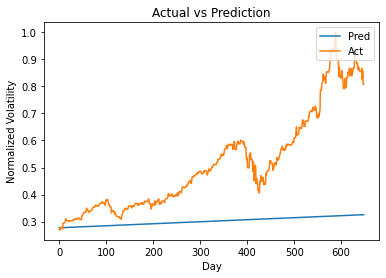

In [ ]:
from matplotlib import pyplot as pyplot
plot_arima_LR_RF(test_data.iloc[:].values, model_predictions)

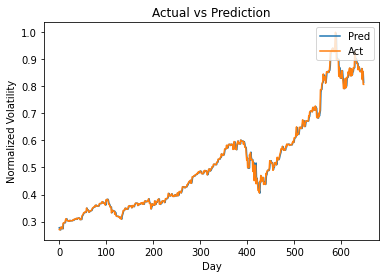

In [ ]:
# ARIMA using true test data


# from matplotlib import pyplot as pyplot
# plot_arima_LR_RF(test_data.iloc[:].values, model_predictions)

In [ ]:
# near perfect result when doing 1 day ahead prediction 

# Data Prep - RF and LR

In [ ]:

F2_new = google_trend_df.iloc[:,2]
F4_new = google_trend_df.iloc[:,4]
F5_new = twitterdf.iloc[:,0]
F7_new = headlines_sent.iloc[:,1]
F8_new = apple_df.iloc[:,1]
Target_new = apple_df.iloc[:,0]
df = pd.concat([F2_new, F4_new, F5_new, F7_new, F8_new, Target_new], axis=1, sort=False)
df

,iPhone: (Worldwide),NASDAQ AAPL: (Worldwide),Twitter_Sent,News_Sent,Lag_Close_value,Close
Month,,,,,,
2009-01-02,0.012658,0.010204,0.571270,0.430211,0.001944,0.003411
2009-01-03,0.012658,0.010204,0.333211,0.254201,0.003411,0.003411
2009-01-04,0.012658,0.010204,0.466627,0.465924,0.003411,0.003411
2009-01-05,0.012658,0.010204,0.513318,0.493364,0.003411,0.004452
2009-01-06,0.012658,0.010204,0.534109,0.543485,0.004452,0.004028
...,...,...,...,...,...,...
2020-10-27,0.506329,0.602041,0.551424,0.465924,0.854400,0.866197
2020-10-28,0.506329,0.602041,0.507635,0.298009,0.866197,0.825097
2020-10-29,0.506329,0.602041,0.518923,0.434814,0.825097,0.856455


In [ ]:
# test and training sets 
X_new = df.iloc[:, 0:5].values
y_new = df.iloc[:, 5].values
X_train_new,X_test_new,y_train_new,y_test_new = train_test_split(X_new, y_new, test_size = 0.15, shuffle = False)



# Linear Regression 

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_new, y_train_new)

# Make predictions using the testing set
pred_LR = regr.predict(X_test_new)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %f'
      % mean_squared_error(y_test_new, pred_LR))
#The coefficient of determination: 1 is perfect prediction


Coefficients: 
 [ 1.25837115e-04 -2.31532609e-03  4.71759998e-03  2.77739854e-03
  1.00018201e+00]
Mean squared error: 0.000147


In [ ]:
# MAPE
def mape_arima_LR_RF(y_test, yhat):
  mape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    mape[x] = (np.abs((y_test[x] - yhat[x])/y_test[x]))*100

  print("Min MAPE %:")
  print(min(mape))
  print("Mean MAPE %:")
  print(sum(mape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(mape))
  print("Max MAPE %:")
  print(max(mape))
  return 

In [ ]:
mape_arima_LR_RF(y_test_new, pred_LR)

Min MAPE %:
0.00011224230510641707
Mean MAPE %:
1.1885487250362015
Median MAPE %:
0.5535083987069206
Max MAPE %:
15.297530492247201


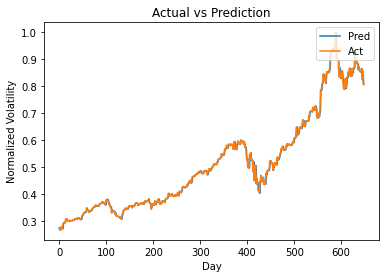

In [ ]:
from matplotlib import pyplot as pyplot
plot_arima_LR_RF(y_test_new, pred_LR)

# Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model 
rf.fit(X_train_new, y_train_new);
predictions = rf.predict(X_test_new)

In [ ]:
mape_arima_LR_RF(y_test_new, predictions)

Min MAPE %:
0.01776580709638014
Mean MAPE %:
18.343295973759673
Median MAPE %:
13.358714176383547
Max MAPE %:
58.440635626654334


In [ ]:
maape_arima(y_test_new, predictions)

Min MAAPE %:
0.0177658069094697
Mean MAAPE %:
17.483203406401554
Median MAPE %:
13.280089909552728
Max MAAPE %:
52.88746719606158
